In [50]:
import numpy as np
import librosa
import joblib  # For loading the Random Forest model
import os

# Load the trained Random Forest model (Ensure it's in .joblib or .pkl format)
model_path = "model_weights.joblib"  # Make sure your model is correctly saved
rf_model = joblib.load("/content/model_weights.joblib")

def load_and_preprocess(file_path):
    """Load and preprocess audio file"""
    audio, sr = librosa.load(file_path, sr=44100)
    audio = librosa.effects.preemphasis(audio)
    return audio, sr

def extract_vocal_features(audio, sr):
    """Extract Parkinson's-relevant vocal features"""
    features = {}


    jitter = librosa.feature.rms(y=audio)
    features['MDVP:Jitter(%)'] = np.std(jitter) / np.mean(jitter)
    features['MDVP:Jitter(Abs)'] = np.mean(np.abs(np.diff(jitter)))
    features['Jitter:RAP'] = np.mean(np.abs(np.diff(jitter, n=2)))
    features['Jitter:PPQ5'] = np.mean(np.abs(np.diff(jitter, n=5)))
    features['Jitter:DDP'] = np.mean(np.abs(np.diff(jitter, n=3)))

    shimmer = librosa.amplitude_to_db(np.abs(librosa.stft(audio)))
    features['MDVP:Shimmer'] = np.mean(np.abs(np.diff(shimmer.mean(axis=0))))
    features['Shimmer(dB)'] = np.mean(shimmer)
    features['Shimmer:APQ3'] = np.mean(np.abs(np.diff(shimmer.mean(axis=0), n=3)))
    features['Shimmer:APQ5'] = np.mean(np.abs(np.diff(shimmer.mean(axis=0), n=5)))
    features['Shimmer:APQ11'] = np.mean(np.abs(np.diff(shimmer.mean(axis=0), n=11)))
    features['Shimmer:DDA'] = np.mean(librosa.feature.rms(y=audio))

    harmonic = librosa.effects.harmonic(audio)
    noise = librosa.effects.percussive(audio)
    features['NHR'] = np.mean(noise) / (np.mean(harmonic) + 1e-8)
    features['HNR'] = 10 * np.log10(np.mean(harmonic**2) / (np.mean(noise**2) + 1e-8))

    rms = librosa.feature.rms(y=audio)
    features['RPDE'] = np.std(rms)

    D = librosa.stft(audio)
    tremor_power = np.mean(np.abs(D[3:8]))

    features['DFA'] = np.mean(np.abs(np.diff(rms)))
    features['PPE'] = np.std(jitter)

    return features

def predict_parkinsons(file_path):
    """Extract features and predict Parkinson's probability"""
    # Extract features from the audio file
    audio, sr = load_and_preprocess(file_path)
    features = extract_vocal_features(audio, sr)

    # Convert feature dictionary to numpy array
    feature_values = np.array(list(features.values())).reshape(1, -1)

    # Predict using the trained model
    prediction = rf_model.predict(feature_values)[0]

    # Normalize the prediction to a percentage
    parkinsons_probability = min(max(prediction, 0), 100)

    print(f"Probability of Parkinson's Disease: {parkinsons_probability:.2f}%")
    return parkinsons_probability

# Example usage
predict_parkinsons("/content/Sample Test- hacknocturne.wav")


Probability of Parkinson's Disease: 33.63%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


np.float64(33.632519)

<ipython-input-51-509551085100>:42: RuntimeWarning: invalid value encountered in log10
  features['HNR'] = 10 * np.log10(np.mean(harmonic*2) / (np.mean(noise*2) + 1e-8))


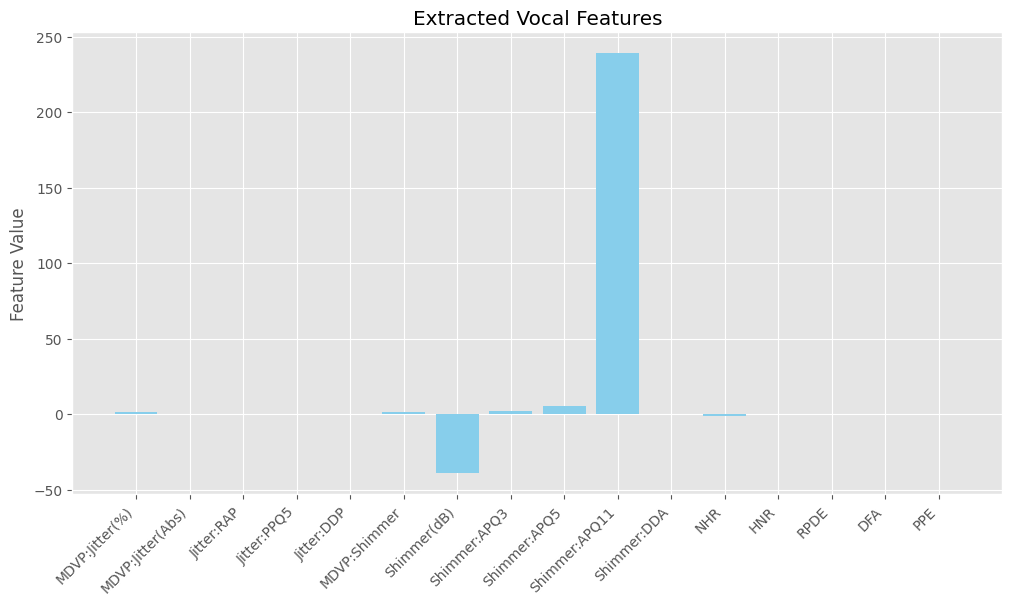


Parkinson's Vocal Feature Analysis Results
MDVP:Jitter(%): 1.4829
MDVP:Jitter(Abs): 0.0009
Jitter:RAP: 0.0006
Jitter:PPQ5: 0.0027
Jitter:DDP: 0.0009
MDVP:Shimmer: 1.6193
Shimmer(dB): -39.3432
Shimmer:APQ3: 2.0162
Shimmer:APQ5: 5.5630
Shimmer:APQ11: 238.8388
Shimmer:DDA: 0.0048
NHR: -1.0378
HNR: nan
RPDE: 0.0072
DFA: 0.0009
PPE: 0.0072


In [51]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal


plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 6]

def load_and_preprocess(file_path):
    """Load and preprocess audio file"""
    audio, sr = librosa.load(file_path, sr=44100)
    audio = librosa.effects.preemphasis(audio)
    return audio, sr

def extract_vocal_features(audio, sr):
    """Extract Parkinson's-relevant vocal features"""
    features = {}

    f0, voiced_flag, _ = librosa.pyin(audio, fmin=75, fmax=300)

    jitter = librosa.feature.rms(y=audio)
    features['MDVP:Jitter(%)'] = np.std(jitter) / np.mean(jitter)
    features['MDVP:Jitter(Abs)'] = np.mean(np.abs(np.diff(jitter)))
    features['Jitter:RAP'] = np.mean(np.abs(np.diff(jitter, n=2)))
    features['Jitter:PPQ5'] = np.mean(np.abs(np.diff(jitter, n=5)))
    features['Jitter:DDP'] = np.mean(np.abs(np.diff(jitter, n=3)))

    shimmer = librosa.amplitude_to_db(np.abs(librosa.stft(audio)))
    features['MDVP:Shimmer'] = np.mean(np.abs(np.diff(shimmer.mean(axis=0))))
    features['Shimmer(dB)'] = np.mean(shimmer)
    features['Shimmer:APQ3'] = np.mean(np.abs(np.diff(shimmer.mean(axis=0), n=3)))
    features['Shimmer:APQ5'] = np.mean(np.abs(np.diff(shimmer.mean(axis=0), n=5)))
    features['Shimmer:APQ11'] = np.mean(np.abs(np.diff(shimmer.mean(axis=0), n=11)))
    features['Shimmer:DDA'] = np.mean(librosa.feature.rms(y=audio))

    harmonic = librosa.effects.harmonic(audio)
    noise = librosa.effects.percussive(audio)
    features['NHR'] = np.mean(noise) / (np.mean(harmonic) + 1e-8)
    features['HNR'] = 10 * np.log10(np.mean(harmonic*2) / (np.mean(noise*2) + 1e-8))

    rms = librosa.feature.rms(y=audio)
    features['RPDE'] = np.std(rms)

    D = librosa.stft(audio)
    tremor_power = np.mean(np.abs(D[3:8]))

    features['DFA'] = np.mean(np.abs(np.diff(rms)))
    features['PPE'] = np.std(jitter)

    return features

def plot_features(features):
    """Plot extracted features in a bar chart"""
    plt.figure(figsize=(12, 6))
    plt.bar(features.keys(), features.values(), color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Feature Value")
    plt.title("Extracted Vocal Features")
    plt.show()

def analyze_parkinsons_voice(file_path):
    """Complete analysis pipeline"""
    audio, sr = load_and_preprocess(file_path)
    features = extract_vocal_features(audio, sr)
    plot_features(features)
    print("\n" + "="*50)
    print("Parkinson's Vocal Feature Analysis Results")
    print("="*50)
    for feature, value in features.items():
        print(f"{feature}: {value:.4f}")
    return features

# Run the analysis on your audio file
features = analyze_parkinsons_voice("/content/Sample Test- hacknocturne.wav")